In [1]:
import torch
import gc
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

import dataloader as defencer

In [2]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [3]:
# Free cuda memory
# Reference: https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/13
def freemem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and torch.is_tensor(obj.data):
            del obj
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

Image train=67581, Fence train=18
Image val=8448, Fence val=9
Image test=8448, Fence test=3


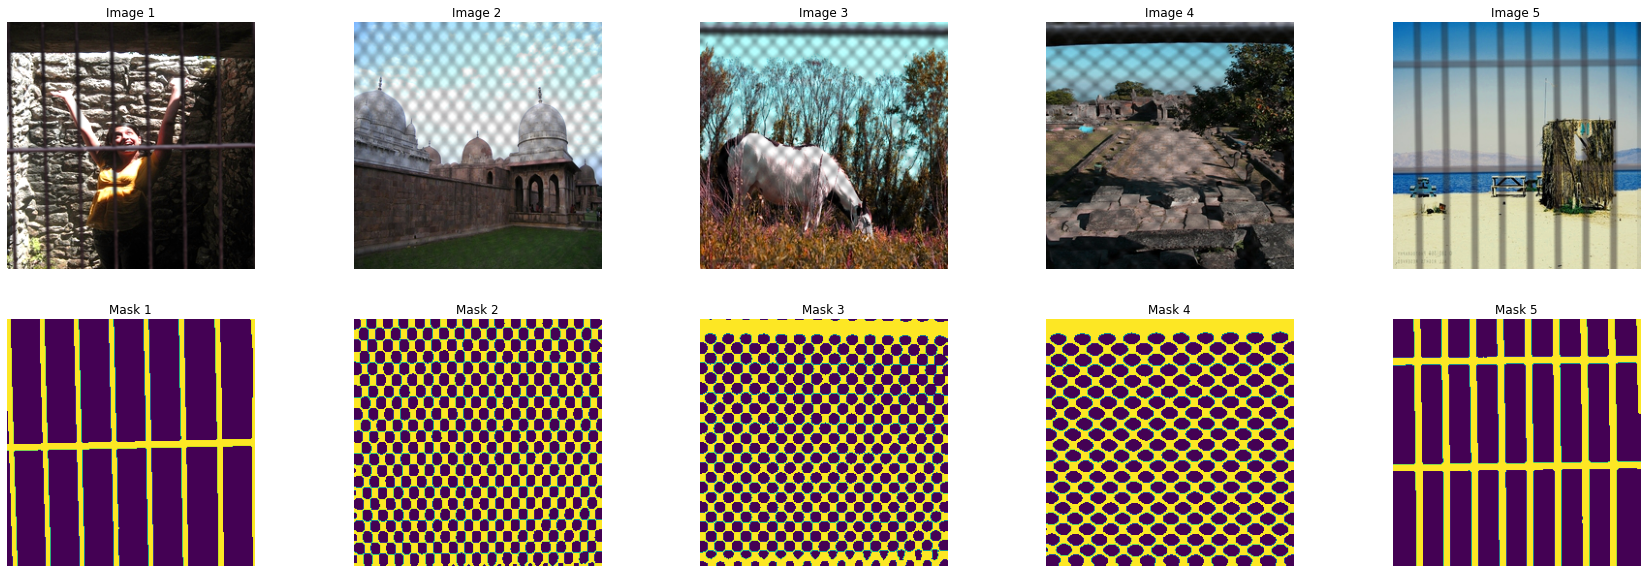

In [4]:
loader_train, loader_val, loader_test = defencer.Get_DataLoaders(16, 4)

In [5]:
resnet50 = models.resnet50(pretrained=True)
x, y = next(iter(loader_val))
resnet50.fc = nn.Linear(2048, 65536)

for param in resnet50.parameters():
    param.require_grad = False
resnet50.fc.requires_grad_(True)

Linear(in_features=2048, out_features=65536, bias=True)

In [6]:
freemem()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet50 = resnet50.to(device)
summary(resnet50, (3, 256, 256))

c:\Users\EthanRuoff\anaconda3\envs\cv\lib\site-packages\torch\distributed\distributed_c10d.py:170: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14      

In [10]:
from segmentation_model import trainer
from segmentation_model import evaluator
from segmentation_model import visualizer

In [11]:
trainer.train(resnet50, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=15)

Training epoch 1 batch 2111/4223, train loss = 0.561019, train acc = 0.712580, recall = 0.162491, precision = nan722
validation metrics at epoch 1 batch 2111: val loss = 0.435708, val acc = 0.796220, val recall = 0.333182, val precision = 0.908016
Training epoch 1 batch 4222/4223, train loss = 0.511173, train acc = 0.741344, recall = 0.260396, precision = nan
validation metrics at epoch 1 batch 4222: val loss = 0.396937, val acc = 0.810543, val recall = 0.391554, val precision = 0.911766
Training epoch 1 batch 4223/4223, train loss = 0.511174, train acc = 0.741342, recall = 0.260402, precision = nan
validation metrics at epoch 1 batch 4223: val loss = 0.393961, val acc = 0.813275, val recall = 0.399654, val precision = 0.908094
Epoch 1/100 train loss = 0.511174, train acc = 0.741342, val loss = 0.393961, val acc = 0.813275
Training epoch 2 batch 2111/4223, train loss = 0.431353, train acc = 0.782693, recall = 0.397565, precision = 0.856059
validation metrics at epoch 2 batch 2111: val 

([0.43570813497133326,
  0.3969365643393813,
  0.39396084901509865,
  0.39034065601387713,
  0.37919359115149937,
  0.3796162616856622,
  0.37829784549434076,
  0.3673594571142034,
  0.3690821191747532,
  0.37502268862656574,
  0.36220332554005313,
  0.36786182032841624,
  0.3479006512259895,
  0.3499906608326869,
  0.3563008896554961,
  0.34644210615167115,
  0.3467262705618685,
  0.3415152830720851,
  0.33930447869793035,
  0.3422676833685149,
  0.33930078981387796,
  0.32523771414928365,
  0.332391317623357,
  0.3193886418064887,
  0.3211251842704686,
  0.3182841988957741,
  0.32039796535603027,
  0.3212848918117357,
  0.31797712931240146,
  0.31700540099744545,
  0.3112918645933722,
  0.3087659032281601,
  0.31351307390088384,
  0.31081455618594633,
  0.30551342906035256,
  0.30881251523158315,
  0.30225161152581376,
  0.3056797892645453,
  0.3020867096034415,
  0.2924883923436882,
  0.2988791973753409,
  0.2949092298266337,
  0.29677957866453764,
  0.3078267499804497,
  0.30618758

In [12]:
for param in resnet50.parameters():
    param.require_grad = True
trainer.train(resnet50, loader_train, loader_val, lr=1e-4, device=device, num_epochs=100, patience=10)

torch.save(resnet50.state_dict(), 'saved_models/resnet50.model')

Training epoch 1 batch 2111/4223, train loss = 0.222860, train acc = 0.889849, recall = 0.787074, precision = 0.862270
validation metrics at epoch 1 batch 2111: val loss = 0.300519, val acc = 0.864807, val recall = 0.725324, val precision = 0.794908
Training epoch 1 batch 4222/4223, train loss = 0.221426, train acc = 0.890715, recall = 0.789545, precision = 0.862847
validation metrics at epoch 1 batch 4222: val loss = 0.300513, val acc = 0.868653, val recall = 0.722990, val precision = 0.807816
Training epoch 1 batch 4223/4223, train loss = 0.221430, train acc = 0.890712, recall = 0.789534, precision = 0.862847
validation metrics at epoch 1 batch 4223: val loss = 0.300637, val acc = 0.867730, val recall = 0.719284, val precision = 0.806731
current_patience = 9
Epoch 1/100 train loss = 0.221430, train acc = 0.890712, val loss = 0.300637, val acc = 0.867730
Training epoch 2 batch 2111/4223, train loss = 0.215952, train acc = 0.894011, recall = 0.798737, precision = 0.865846
validation me

Accuracy = 89.1885757446289%
Precision = 79.82463836669922%
Recall = 75.78576803207397%


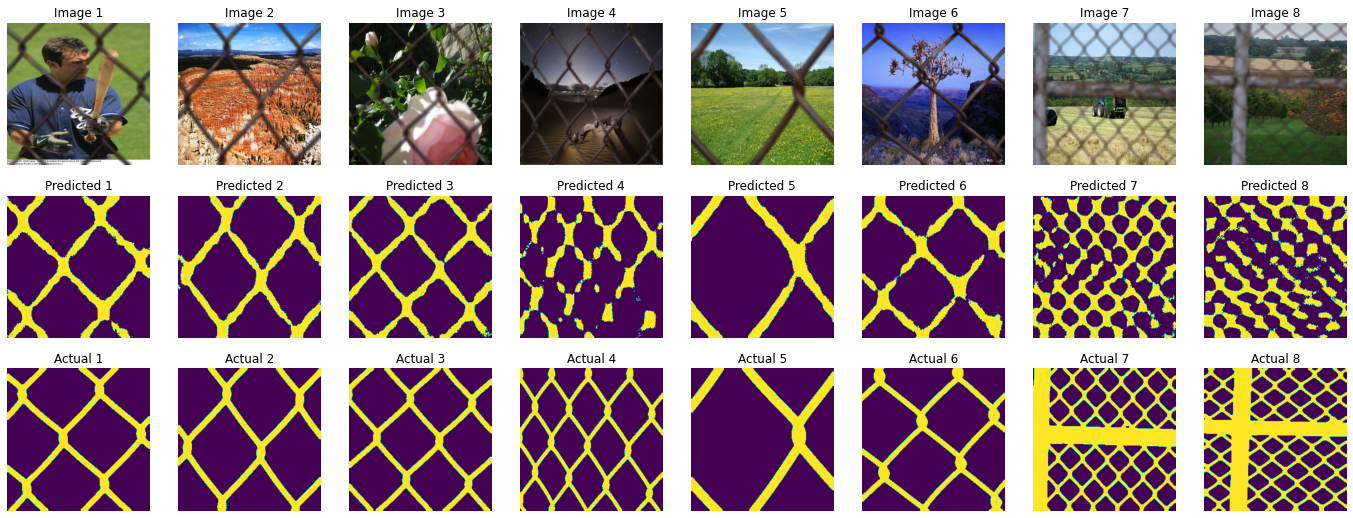

In [16]:
visualizer.visualize_model_output(loader_test, resnet50, device=device)